# TIME SERIES 

Whether we wanted to predict the financial market or electricity consumption, time becomes the important factor to be considered in our model.

We would not only want to know ups and downs of stock market but also **when** it happens

A time series is simply a series of data points ordered in time.

In a time series, time is often the independent variable and the goal is usually to make a forecast for the future.

### BUSSINESS PROBLEM

Making decision on investment in the right stock market

### DESCRIPTION

When a company or person plans to invest his/her capital in stock, he/she would prefer to have profit. So he/she should analyse which stock is better to invest in. 

how will they analyse ?
**And thats where our problem statement starts**

# PROBLEM STATEMENT :  FORCASTING OF THE STOCK MARKET

Our Aim here is to create a model that can predit the future stock price based on the model training and provided dataset.

### OBJECTIVE

- Predict stock price in next day
- Given prices for the last N days, we do prediction for day N+1

### STEPS :
1. Importing Libraries
2. Exploring the Dataset
3. Exploratory Data Analysis
> * Univariate Analysis
4. Data Preprocessing
5. Model Building
> * AUTOREGRESSIVE MODEL
> * MOVING AVERAGE MODEL
6. Evaluation
> * MEAN SQUARE ERROR
> * MEAN ABSOLUTE ERROR
> * ROOT MEAN SQUARE ERROR
7. Conclusion

### DATA
We will be using a [Huge stock market dataset](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) from the Kaggle platform which has a very good collection of datasets.The file we will be using is present in following directory in the dataset zip file input\Data\Stocks\gs.us.txt
  
The data is presented in CSV format as follows : Date, Open, High, Low, Close, Volume, OpenInt.

Features:
  - Date
  - Open
  - High
  - Low
  - Close
  - Volume
  - OpenInt
  
Note that prices have been adjusted for dividends and splits.

### LIBRARIES IMPORTED

In [99]:
# Imported libraries
import numpy as np  #linear algebra
import pandas as pd # data processing and I/O csv file 
import matplotlib.pyplot as plt # MATPLOT format plot
import matplotlib.dates as mdates #Dates format (YYYY-MM-DD)
%matplotlib inline 

from math import sqrt #simple math library
from sklearn.preprocessing import MinMaxScaler  #Scales within the range 
from sklearn.metrics import mean_squared_error, mean_absolute_error #evaluation metrics

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Ignore warnings
import warnings 
def ignore_warn(*args,**kwargs):
  pass
warnings.warn=ignore_warn

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm

### PREPROCESSING

We will be using **gs.us.txt** dataset

In [100]:
""" function that takes in the date from the parse_dates and converts into YYYY-MM-DD format """

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [101]:
""" Loading the CSV file that contains the data and 
    parsing the "Date" column to get in the format YYYY-MM-DD and
    defining "Data" column as index for the dataframe"""

df = pd.read_csv('input/Data/Stocks/gs.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)

#to do task_1
#display the top 10 rows of the dataframe called "data" as displayed down 
#if you run this file you wont be able to see the display below
df.head(10)

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1999-05-04,67.665,68.780,62.329,62.659,24472946,0
1999-05-05,62.213,62.213,58.991,61.547,8295140,0
1999-05-06,60.542,61.773,59.712,60.488,3185852,0
1999-05-07,60.488,66.671,59.429,65.998,5331091,0
1999-05-10,65.331,65.441,62.549,62.941,2839054,0
1999-05-11,62.329,63.389,61.885,62.888,2017182,0
1999-05-12,63.216,66.671,61.547,65.441,2915697,0
1999-05-13,65.222,67.000,64.555,65.166,1253094,0
1999-05-14,63.444,64.329,61.491,62.497,2256860,0


Note down that the data we are using is well organised so we don't have to do lot of preprocessing 
But if you have a data which is not organised then its vey important to do **PREPROCESSING** in very standard way to get better model to do best predictions.

**GARBAGE IN IS GARBAGE OUT**

Rightly said atleast in machine learning if you give unrelated input you will always get unrelated output so preprocess the input data always

### EXPLORATORY DATA ANALYSIS (EDA)

#### PLOT 

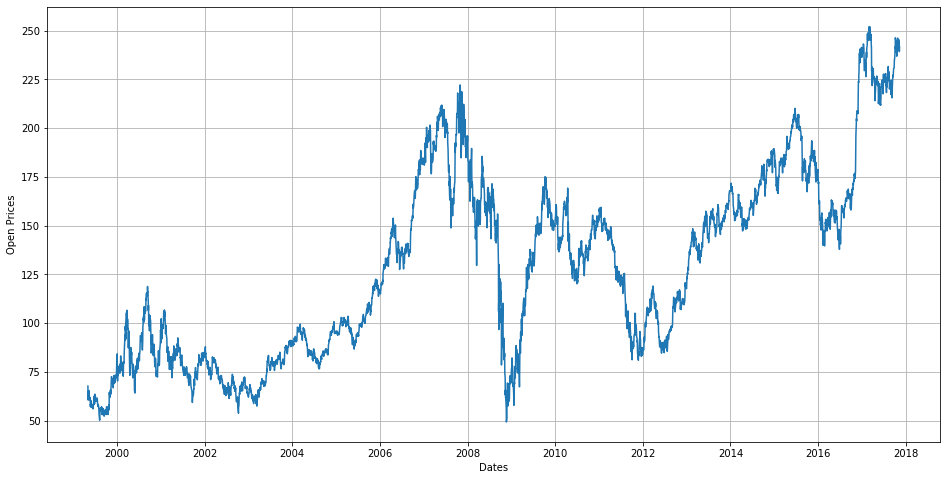

In [102]:
#to do task_2
# Ploting "Open Prices" against "Dates"
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['Open']);

**NOTE**

When solving a time series problem statement we should always ask these questions
    - Is it stationary?
    - Is there a seasonality?
    - Is the target variable autocorrelated?

**AUTOCORRELATION PLOT**

Autocorrelation is the similarity between observations as a function of the time lag between them.

In [103]:
values = DataFrame(df['Open'].values)
dataframe = concat([values,values.shift(1),values.shift(5),values.shift(10),values.shift(30)], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.998288  0.992929  0.987001  0.954921
t+1   0.998288  1.000000  0.994216  0.988282  0.956678
t+5   0.992929  0.994216  1.000000  0.992890  0.963463
t+10  0.987001  0.988282  0.992890  1.000000  0.971829
t+30  0.954921  0.956678  0.963463  0.971829  1.000000


**SEASONALITY**

Seasonality refers to periodic fluctuations.

For example, temperature is high during the day and low during night,or online sales increase during Festival before slowing down again.

Remember that seasonality can also be derived from an autocorrelation plot if it has a sinusoidal shape.
Simply look at the period, and it gives the length of the season.

**STATIONARITY**

Stationarity is an important characteristic of time series. 

A time series is said to be stationary if its statistical properties do not change over time.

In other words, it has constant mean and variance, and covariance is independent of time.


**Dickey-Fuller Method to check for seasonality and stationarity**

It test the null hypothesis that a unit root is present.

If it is, then p > 0, and the process is not stationary.

Otherwise, p = 0, the null hypothesis is rejected, and the process is considered to be stationary.

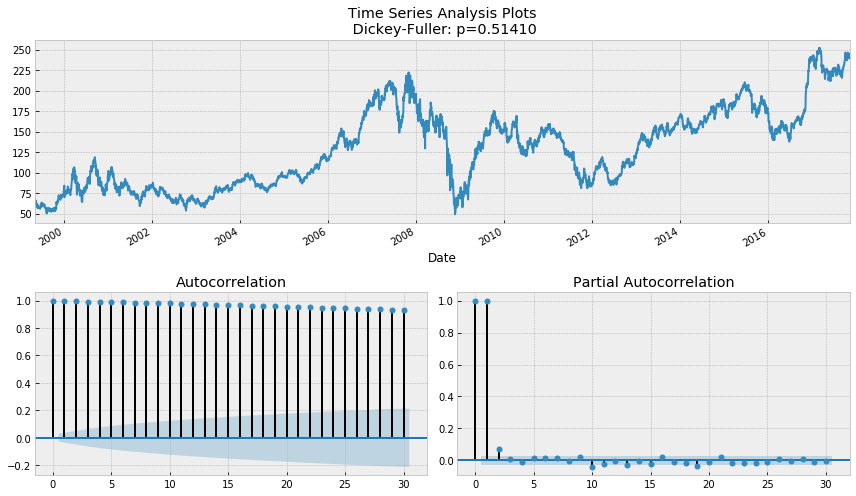

In [104]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.Open, lags=30)

By the Dickey-Fuller test, the time series is non-stationary. Notice how the mean is not constant through time. 

Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.

**NOTE**

Ideally, we want to have a stationary time series for modelling.

Of course, not all of them are stationary, but we can make different transformations to make them stationary.


Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference. We simply the time series from itself with a lag of one day:

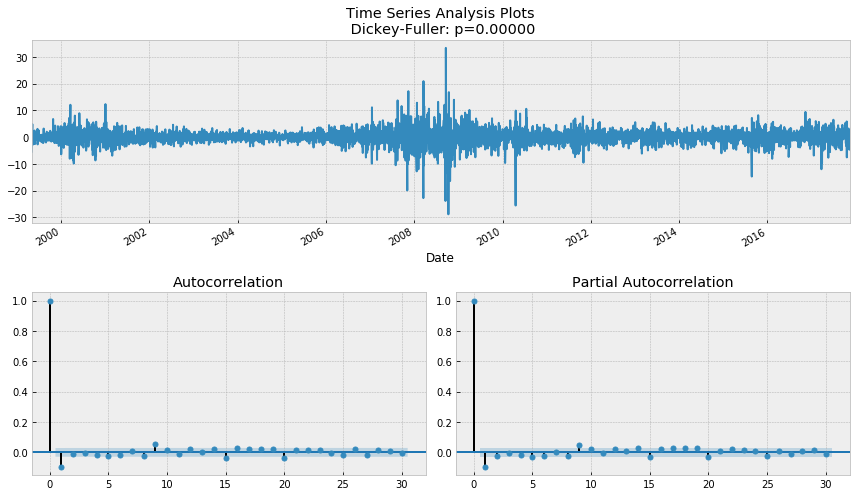

In [105]:
#to do task_4
#take the difference betweeen the data and data shifted by 1
#check if it stationary or not using Dickey-Fuller method
data = df.copy(deep=False)
data1 = df.copy(deep=False)
data1.Open = data1.Open - data1.Open.shift(1)
tsplot(data1.Open[1:], lags=30)

Since p = 0 it is stationary. 

We can start modeling

### TRAIN-TEST SPLIT

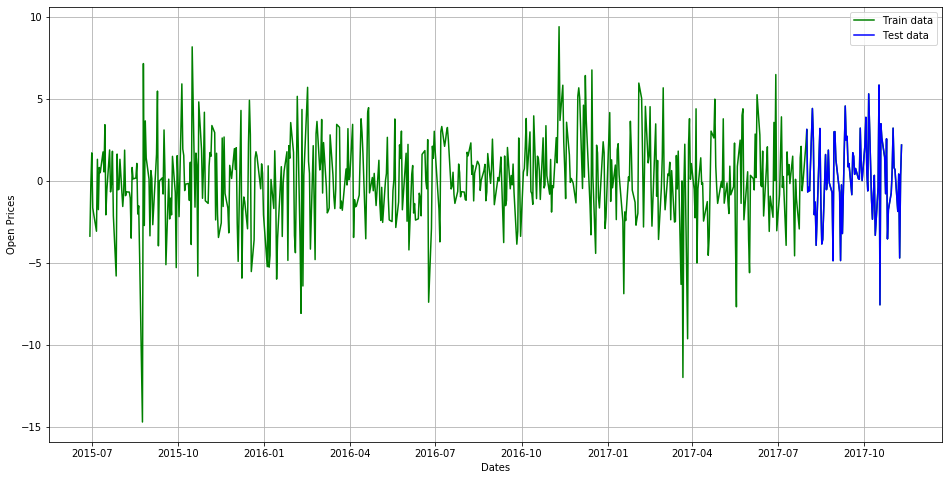

In [106]:
# TO DO TASK_5
# split the data with test set containing last 73 images and train set containing remaining images
# plot the train set with green color and test set with blue
train_data, test_data = data[1:-73], data[-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

### MEAN VALUE PLOT

MSE: 6.614792639144097
MAE: 1.9907383591040042
RMSE: 2.571923917837403


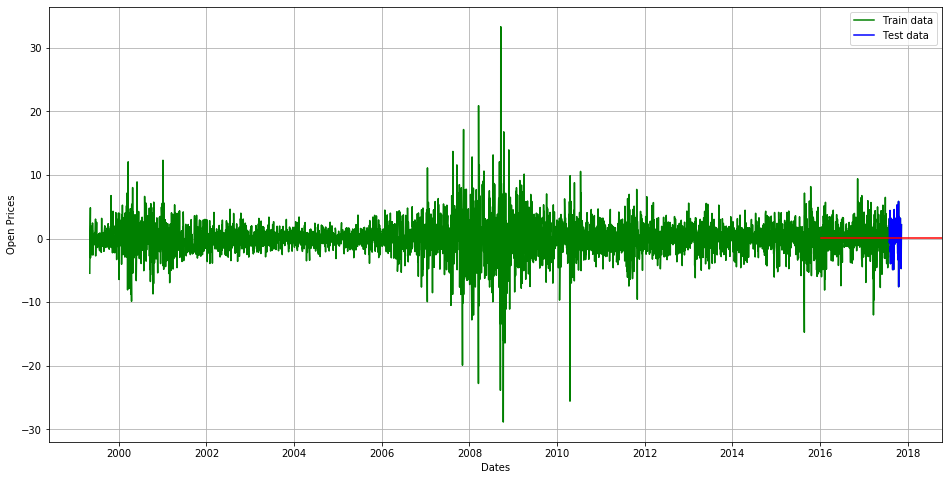

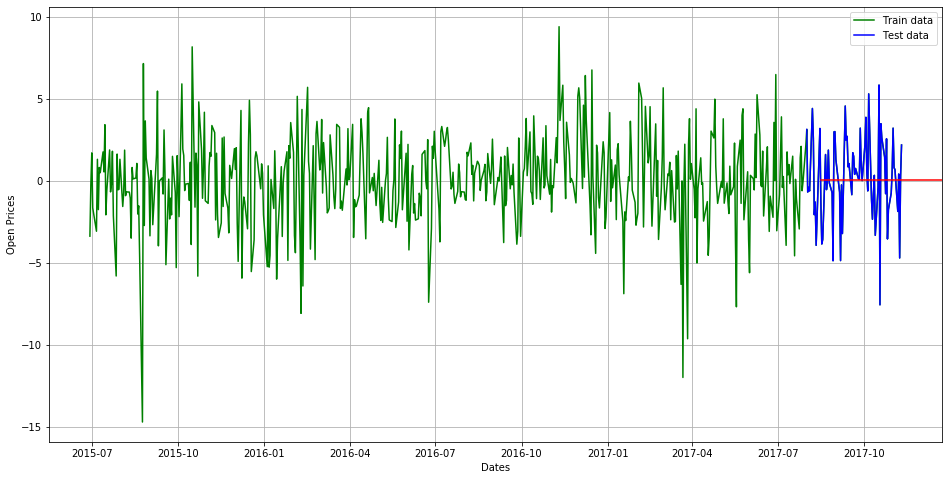

In [107]:
# this is done to check if we give predicted value as mean of the dataset What value MSE,MAE,RMSE will take.
mean_value = data['Open'].mean() # calculation of mean price

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

# to do task_6
#print the value of MSE ,MAE,RMSE
print('MSE: '+str(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('MAE: '+str(mean_absolute_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value)))))

### MODEL BUILDING AND VALIDATION

**AUTOREGRESSIVE MODEL**

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.

Observation from previous time observation as input to a regression equation for next prediction

References:
 - https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

Lag: 31
MSE: 6.564935200370728
MAE: 2.0082033669768165
RMSE: 2.5622129498483783


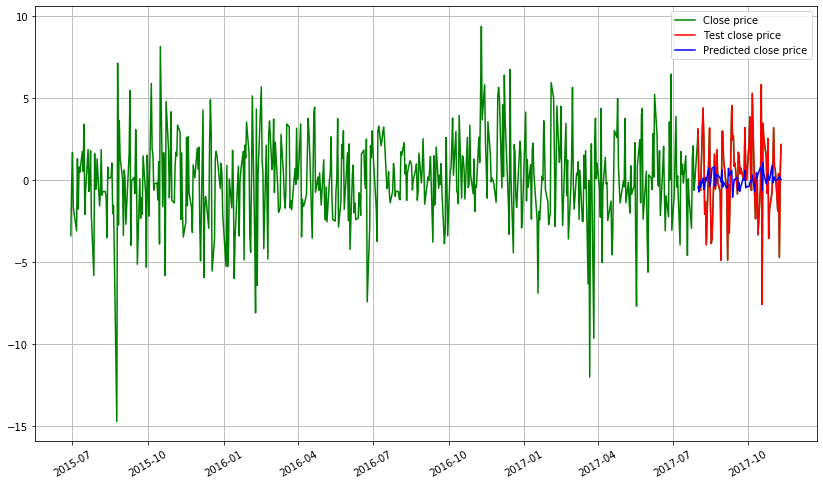

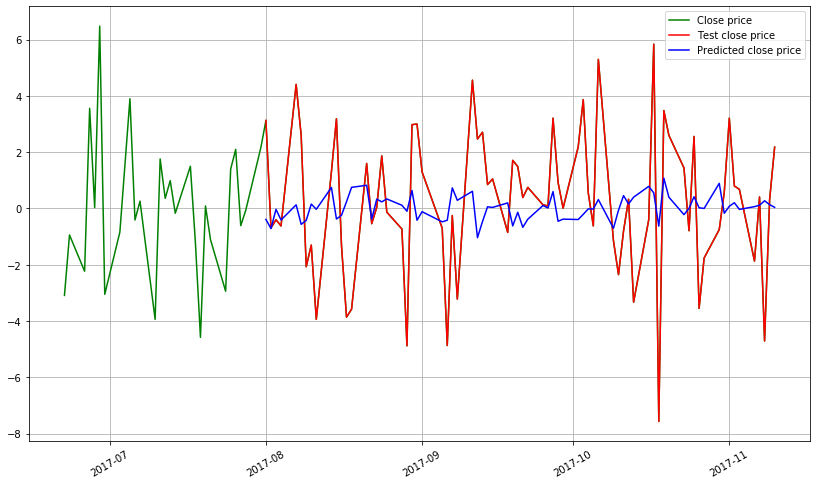

In [108]:
train_ar = train_data['Open']
test_ar = test_data['Open']

#TO DO TASK_7
#train the autoregressive model and fit it
model = AR(train_ar)# train autoregression
model_fit = model.fit()

window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]

predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
 
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['Open'], predictions)))
print('MAE: '+str(mean_absolute_error(test_data['Open'], predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Open'], predictions))))

# Moving Average model

In time series analysis, the moving-average model (MA model), also known as moving-average process, is a common approach for modeling univariate time series.

The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

Reference:
    - https://en.wikipedia.org/wiki/Moving-average_model

In [ ]:
train_ma = train_data['Open']
test_ma = test_data['Open']

history = [x for x in train_ma]
y = test_ma
# make first prediction
predictions = list()
model = ARMA(history, order=(0,8))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)

# TO DO TASK 8
# FORECAST USING THE TRAINED MODEL
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARMA(history, order=(0,8))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

FURTURE READING :
 - https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model
 - https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html